# Yandex Analyst (trainee)


## Задание:

1. Скачать Access Log серверов NASA за июль 1995 года [отсюда][1];
- [Распарсить файл в Pandas DataFrame](#2.-DataFrame);
- [Посчитать количество обращений к каждому урлу](#3.-Посчитаем-количество-обращений-к-каждому-урлу);
- [Найти топ-15 самых посещаемых урлов](#4.-Найдем-топ-15-самых-посещаемых-урлов);
- [Посчитать число запросов в секунду](#5.-Посчитаем-число-запросов-в-секунду);
- [Нарисовать график числа запросов в секунду](#6.-Нарисуем-график-числа-запросов-в-секунду);
- [Построить гистограмму распределения размеров запросов](#7.-Построим-гистограмму-распределения-размеров-запросов).

[1]: http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html 

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import re
import plotly.offline as offline
from plotly.graph_objs import *
import matplotlib.pyplot as plt

In [2]:
# Класс-парсер исходного файла
class LogToDataFrame:
    def __init__(self, file_name):
        '''Конструктор класса. Принимает название лог файла тип str.
        '''
        self.data = open(file_name, 'r', encoding='CP1251').readlines()[:-1]

    def get_DataFrame(self):
        '''Метод класса. Возвращает обьект DataFrame,
        заполняет пропуски в данных обьектом None.
        '''
        _list = []
        for line in self.data:
            host = re.search(r'^([^\s]+\s)', line)
            if host is not None:
                host = host.group(1)
            date = re.search(r'^.*\[(\d\d/\w{3}/\d{4}:\d{2}:\d{2}:\d{2}) -\d{4}]', line)
            if date is not None:
                date = date.group(1)
                date = date.replace('/','-',2).replace('Jul','07').replace(':',' ',1)
            method = re.search(r'^.*"(\w+)\s+', line)
            if method is not None:
                method = method.group(1)
            request = re.search(r'^.*"\w+\s+([^\s]+).*"', line)
            if request is not None:
                request = request.group(1)
            version = re.search(r'\s+(HTTP.*)"', line)
            if version is not None:
                version = version.group(1)
            status = re.search(r'^.*"\s+([^\s]+)', line)
            if status is not None:
                status = status.group(1)
            content_size = re.search(r'^.*\s+(\d+)$', line)
            if content_size is not None:
                content_size = content_size.group(1)
            _list.append([
                host, date, method, request,
                version, status, content_size
            ])
        return pd.DataFrame(_list, columns=[
            'Host', 'Date', 'Method', 'Request',
            'Version', 'Status', 'Content size'])

### 2. DataFrame

In [3]:
df = LogToDataFrame('NASA_access_log_Jul95').get_DataFrame()

Размер DataFrame:

In [4]:
df.shape

(1891714, 7)

Посмотрим на первые и последние пять записей в данных:

In [5]:
# Начало
df.head(5)

,Host,Date,Method,Request,Version,Status,Content size
0,199.72.81.55,01-07-1995 00:00:01,GET,/history/apollo/,HTTP/1.0,200,6245
1,unicomp6.unicomp.net,01-07-1995 00:00:06,GET,/shuttle/countdown/,HTTP/1.0,200,3985
2,199.120.110.21,01-07-1995 00:00:09,GET,/shuttle/missions/sts-73/mission-sts-73.html,HTTP/1.0,200,4085
3,burger.letters.com,01-07-1995 00:00:11,GET,/shuttle/countdown/liftoff.html,HTTP/1.0,304,0
4,199.120.110.21,01-07-1995 00:00:11,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,HTTP/1.0,200,4179


In [6]:
# Конец
df.tail(5)

,Host,Date,Method,Request,Version,Status,Content size
1891709,163.205.53.14,28-07-1995 13:32:22,GET,/shuttle/technology/images/srb_mod_compare_6-s...,HTTP/1.0,200,28219
1891710,163.205.53.14,28-07-1995 13:32:23,GET,/images/KSC-logosmall.gif,HTTP/1.0,200,1204
1891711,tiger2.ocs.lsu.edu,28-07-1995 13:32:23,GET,/shuttle/missions/missions.html,HTTP/1.0,200,8677
1891712,199.0.2.27,28-07-1995 13:32:23,GET,/images/ksclogo-medium.gif,HTTP/1.0,200,5866
1891713,tornado.umd.edu,28-07-1995 13:32:25,GET,/shuttle/missions/sts-74/sts-74-patch-small.gif,HTTP/1.0,200,5494


### 3. Посчитаем количество обращений к каждому урлу

In [7]:
df['Request'].value_counts()

/images/NASA-logosmall.gif                             111388
/images/KSC-logosmall.gif                               89639
/images/MOSAIC-logosmall.gif                            60468
/images/USA-logosmall.gif                               60014
/images/WORLD-logosmall.gif                             59489
/images/ksclogo-medium.gif                              58802
/images/launch-logo.gif                                 40871
/shuttle/countdown/                                     40279
/ksc.html                                               40231
/images/ksclogosmall.gif                                33585
/                                                       32910
/history/apollo/images/apollo-logo1.gif                 31072
/shuttle/missions/missions.html                         24865
/htbin/cdt_main.pl                                      22626
/shuttle/countdown/count.gif                            22216
/shuttle/countdown/liftoff.html                         22000
/shuttle

### 4. Найдем топ-15 самых посещаемых урлов

In [8]:
df['Request'].value_counts().head(15)

/images/NASA-logosmall.gif                 111388
/images/KSC-logosmall.gif                   89639
/images/MOSAIC-logosmall.gif                60468
/images/USA-logosmall.gif                   60014
/images/WORLD-logosmall.gif                 59489
/images/ksclogo-medium.gif                  58802
/images/launch-logo.gif                     40871
/shuttle/countdown/                         40279
/ksc.html                                   40231
/images/ksclogosmall.gif                    33585
/                                           32910
/history/apollo/images/apollo-logo1.gif     31072
/shuttle/missions/missions.html             24865
/htbin/cdt_main.pl                          22626
/shuttle/countdown/count.gif                22216
Name: Request, dtype: int64

### 5. Посчитаем число запросов в секунду

In [9]:
count = df['Date'].value_counts()

Посмотрим на результат:

In [10]:
count

13-07-1995 13:32:58    20
13-07-1995 09:42:19    18
13-07-1995 13:32:59    18
13-07-1995 09:42:20    17
13-07-1995 08:35:02    16
13-07-1995 09:49:30    16
11-07-1995 14:47:44    16
13-07-1995 09:27:16    15
13-07-1995 08:56:34    15
05-07-1995 16:29:15    15
13-07-1995 09:34:06    15
17-07-1995 14:20:57    15
12-07-1995 13:39:35    15
13-07-1995 13:28:16    14
13-07-1995 09:51:31    14
13-07-1995 09:05:34    14
05-07-1995 11:41:10    14
13-07-1995 10:41:32    14
13-07-1995 09:51:04    14
13-07-1995 09:34:52    14
13-07-1995 09:38:22    14
12-07-1995 13:34:59    14
24-07-1995 13:03:50    14
13-07-1995 09:40:57    14
14-07-1995 10:38:14    14
13-07-1995 09:49:48    13
13-07-1995 09:47:19    13
13-07-1995 11:27:50    13
06-07-1995 16:03:11    13
10-07-1995 13:16:06    13
                       ..
21-07-1995 15:44:55     1
04-07-1995 03:26:10     1
26-07-1995 20:52:06     1
02-07-1995 16:13:53     1
27-07-1995 13:19:27     1
17-07-1995 16:15:41     1
02-07-1995 21:22:06     1
27-07-1995 0

### 6. Нарисуем график числа запросов в секунду

Добавим в исходный DataFrame столбец с значениями числа запросов в секунду:

In [11]:
df['PRS'] = df['Date'].map(count)

Посмотрим на результат:

In [12]:
df.head(5)

,Host,Date,Method,Request,Version,Status,Content size,PRS
0,199.72.81.55,01-07-1995 00:00:01,GET,/history/apollo/,HTTP/1.0,200,6245,1
1,unicomp6.unicomp.net,01-07-1995 00:00:06,GET,/shuttle/countdown/,HTTP/1.0,200,3985,1
2,199.120.110.21,01-07-1995 00:00:09,GET,/shuttle/missions/sts-73/mission-sts-73.html,HTTP/1.0,200,4085,1
3,burger.letters.com,01-07-1995 00:00:11,GET,/shuttle/countdown/liftoff.html,HTTP/1.0,304,0,2
4,199.120.110.21,01-07-1995 00:00:11,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,HTTP/1.0,200,4179,2


Сделаем выборку уникальных записей по колонке 'Date' в отдельный DataFrame:

In [13]:
gdf = df[['Date', 'PRS']].drop_duplicates()

In [14]:
gdf.head(5)

,Date,PRS
0,01-07-1995 00:00:01,1
1,01-07-1995 00:00:06,1
2,01-07-1995 00:00:09,1
3,01-07-1995 00:00:11,2
5,01-07-1995 00:00:12,3


In [15]:
gdf.shape

(1099798, 2)

Нарисуем интерактивный график используя библиотеку Plotly:

In [ ]:
# Для работы в offline, на GitHub не работает
offline.init_notebook_mode()

trace = Scatter(
    x=gdf.Date,
    y=gdf.PRS,
    line = dict(width = 0.25)
)

data = Data([trace])
offline.iplot(data)

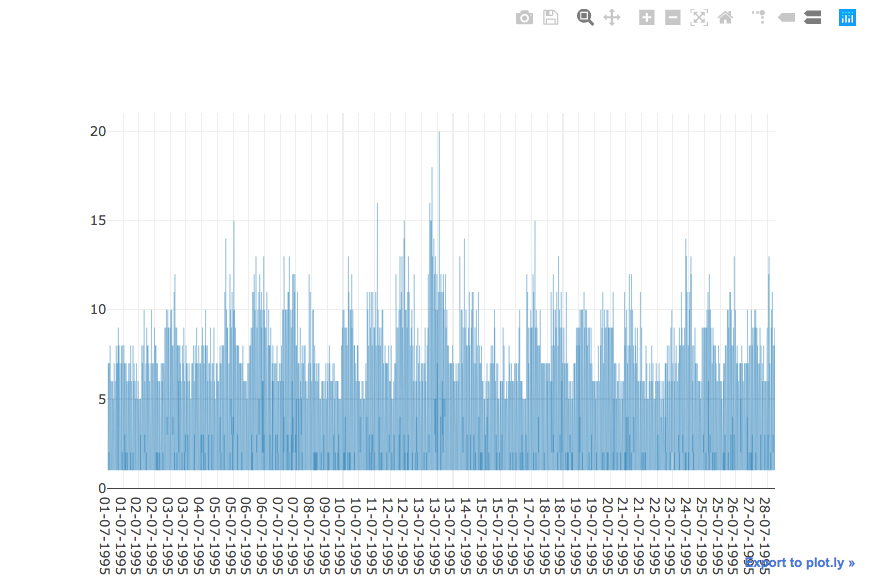

In [18]:
# Импортируем изображение полученое в offline
from IPython.display import Image
Image("yandex_one.png")

### 7. Построим гистограмму распределения размеров запросов

Добавим в исходный DataFrame столбец с значениями размеров запросов:

In [16]:
# Удалим пропуски в данных по запросам
ndf = df.dropna(subset=['Request'])
# Series длин запросов
ndf = ndf['Request'].map(len)

In [17]:
ndf.shape

(1891709,)

Гистограмма:

In [ ]:
# Для работы в offline, на GitHub не работает
trace = Histogram(
    x=ndf
)

data = Data([trace])
offline.iplot(data)

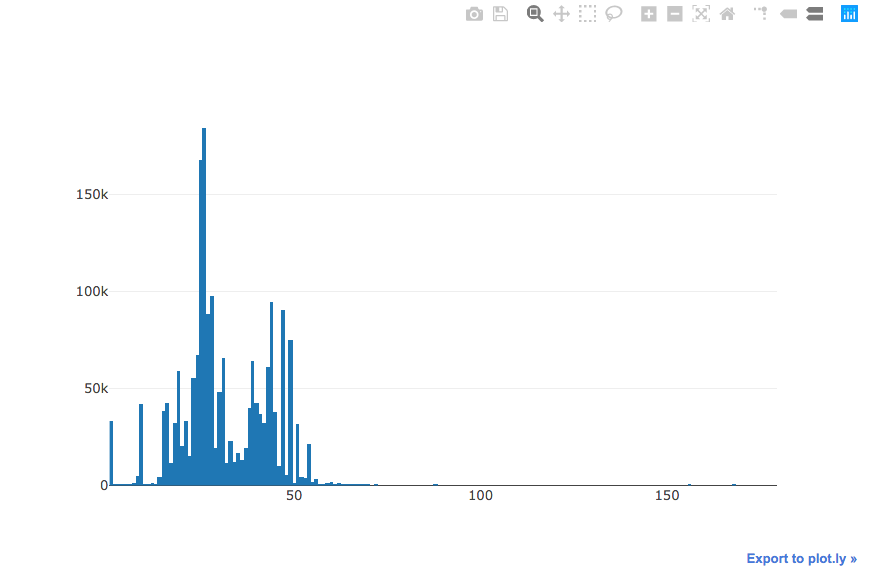

In [19]:
# Импортируем изображение полученое в offline
from IPython.display import Image
Image("yandex_two.png")